<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries used

In [8]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             accuracy_score, hamming_loss, jaccard_score, make_scorer)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import xgboost as xgb

from joblib import dump, load

In [9]:
train_file = "data/processed/raw/train_s_aureus_driams.csv"
train_bac = pd.read_csv(train_file)
train_bac

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,9993,9994,9995,9996,9997,9998,9999,Oxacillin,Clindamycin,Fusidic acid
0,0.018721,0.016147,0.016983,0.021218,0.020846,0.019784,0.019405,0.023356,0.026224,0.026569,...,0.037966,0.030364,0.037545,0.040851,0.034176,0.046110,0.025638,0.0,0.0,0.0
1,0.009001,0.007475,0.006874,0.008575,0.009539,0.007894,0.008314,0.008013,0.008664,0.008923,...,0.014496,0.024966,0.027437,0.026541,0.022940,0.020572,0.032504,0.0,0.0,0.0
2,0.022354,0.020220,0.020910,0.024631,0.021436,0.021197,0.020229,0.018818,0.018637,0.018815,...,0.024620,0.022942,0.026715,0.032045,0.030431,0.029085,0.013117,0.0,0.0,0.0
3,0.017619,0.016073,0.016407,0.018011,0.019364,0.018950,0.017607,0.019116,0.023623,0.024492,...,0.051312,0.047458,0.049338,0.055039,0.054541,0.058643,0.058919,0.0,0.0,0.0
4,0.008264,0.008229,0.006753,0.006657,0.010107,0.007039,0.008250,0.010670,0.008134,0.006513,...,0.236769,0.217499,0.187244,0.216243,0.221910,0.226531,0.221965,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,0.056616,0.039011,0.040380,0.048517,0.050865,0.047771,0.049312,0.048257,0.049417,0.049000,...,0.021169,0.023617,0.033694,0.021037,0.018727,0.010641,0.009238,0.0,1.0,0.0
2820,0.125837,0.107712,0.109186,0.107613,0.109855,0.105060,0.099640,0.104169,0.120303,0.125067,...,0.082375,0.083446,0.096510,0.084883,0.092228,0.085599,0.042142,0.0,1.0,0.0
2821,0.000000,0.000000,0.035603,0.039994,0.042372,0.046666,0.045781,0.043914,0.039875,0.037170,...,0.006903,0.008322,0.011071,0.010274,0.004682,0.003547,0.001744,0.0,0.0,0.0
2822,0.005443,0.005998,0.003670,0.005588,0.006124,0.005019,0.004853,0.005400,0.004169,0.005151,...,0.049241,0.039586,0.050542,0.039139,0.046816,0.043036,0.037402,1.0,1.0,0.0


In [10]:
test_file = "data/processed/raw/test_s_aureus_driams.csv"
test_bac = pd.read_csv(test_file)
test_bac

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,9993,9994,9995,9996,9997,9998,9999,Oxacillin,Clindamycin,Fusidic acid
0,0.044453,0.032486,0.032540,0.034223,0.037528,0.039503,0.031378,0.035506,0.037688,0.035658,...,0.247814,0.263833,0.279904,0.264432,0.241573,0.266020,0.231517,0.0,0.0,0.0
1,0.004318,0.001881,0.001274,0.000902,0.000892,0.000049,0.002188,0.002001,0.003081,0.003384,...,0.033364,0.042735,0.066426,0.057485,0.052903,0.050839,0.036631,0.0,0.0,0.0
2,0.026184,0.026459,0.025393,0.028609,0.031314,0.031739,0.033337,0.028051,0.028047,0.028978,...,0.086746,0.087719,0.094103,0.080969,0.073970,0.069047,0.070988,0.0,1.0,0.0
3,0.000000,0.015010,0.017782,0.014582,0.015084,0.018046,0.014461,0.014400,0.018769,0.018272,...,0.005062,0.006748,0.004573,0.007583,0.008427,0.004729,0.002394,0.0,0.0,1.0
4,0.060499,0.043034,0.030296,0.032635,0.031272,0.032762,0.031154,0.030382,0.030233,0.029438,...,0.029452,0.033288,0.039230,0.046477,0.037219,0.022227,0.019920,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.013092,0.011730,0.009902,0.013513,0.015317,0.011370,0.013338,0.010117,0.010994,0.009222,...,0.050851,0.046334,0.042840,0.061644,0.066948,0.061007,0.056178,0.0,0.0,0.0
703,0.021222,0.015896,0.015512,0.017995,0.018663,0.019427,0.018667,0.014589,0.016765,0.015071,...,0.047285,0.056455,0.058002,0.055528,0.043539,0.039962,0.034761,1.0,0.0,0.0
704,0.045613,0.041040,0.046177,0.050216,0.046525,0.048843,0.045920,0.044283,0.043983,0.046330,...,0.104234,0.094692,0.090012,0.096624,0.092228,0.100024,0.043682,0.0,0.0,1.0
705,0.015193,0.011922,0.010877,0.009975,0.010474,0.012171,0.010417,0.010783,0.013170,0.014157,...,0.051772,0.058255,0.074609,0.068249,0.049157,0.070229,0.043615,1.0,0.0,0.0


In [11]:
train_x = train_bac[train_bac.columns.drop(list(train_bac.filter(regex='[^0-9]')))]
test_x = test_bac[test_bac.columns.drop(list(test_bac.filter(regex='[^0-9]')))]

In [12]:
antibiotics = train_bac.columns.drop(train_x.columns)

In [13]:
train_y = train_bac[antibiotics]
test_y = test_bac[antibiotics]

In [29]:
def multilabel_f1_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(true, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=f1_score(true[:, column], pred[:, column], average=average)
        column+=1
    return total/(column)

In [15]:
def report(true, pred):
        
    hl = hamming_loss(true, pred)
    f1w = multilabel_f1_wrapper(true, pred, "weighted")
    acc = accuracy_score(true, pred)
    
    f1u = multilabel_f1_wrapper(true, pred, "macro")
    f1su = f1_score(true, pred, average="macro")
    f1sw = f1_score(true, pred, average="weighted")

    
    print("Main metrics:")
    print(" Hamming Loss:", hl)
    print(" Accuracy:", acc)
    print(" F1 Score (Weighted):", f1w)
    print("================================================")
    print("Other metrics:")
    print(" F1 Score (Unweighted):", f1u)
    print(" F1 Score (sklearn Unweighted):", f1su)
    print(" F1 Score (sklearn Weighted):", f1sw)
    return hl, acc, f1w

___


In [36]:
bayesopt = BayesSearchCV(
    ClassifierChain(xgb.XGBClassifier(), random_state=0),
    {
        "base_estimator__objective": Categorical(["binary:logistic"]),
        "base_estimator__max_depth": Integer(1, 10),
        "base_estimator__min_child_weight": Real(1e-6, 10, prior="log-uniform"),
        "base_estimator__max_delta_step": Real(1e-6, 10, prior="log-uniform"),
        "base_estimator__subsample": Real(1e-6, 1, prior="log-uniform"),
        "base_estimator__tree_method": Categorical(["exact", "approx", "hist"]),
        "base_estimator__scale_pos_weight": Real(1e-6, 10, prior="log-uniform"),
        "base_estimator__gamma": Real(1e-6, 10, prior="log-uniform"),
        "base_estimator__eta": Real(1e-6, 1, prior="log-uniform")
    },
    n_iter=600,
    cv=5,
    random_state=0,
    n_jobs=5,
    n_points=2,
    scoring=make_scorer(multilabel_f1_wrapper),
    verbose=1
)

bayesopt.fit(train_x, train_y)

print("Best score:", bayesopt.best_score_)
print("Best parameter combination found:", bayesopt.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: 

We then use the model constructed by the parameter optimizer to predict the test data see how it performs.

In [19]:
model = bayesopt.best_estimator_
model.fit(train_x, train_y) 
pred = model.predict(test_x)
model_hl, model_acc, model_js, model_f1 = report(test_y, (pred > 0.5))

Main metrics:
 Hamming Loss: 0.09824046920821114
 Accuracy: 0.7565982404692082
 Jaccard Score (Weighted): 0.8242632743158126
 F1 Score (Weighted): 0.8850588072459757
Other metrics:
 Jaccard Score (Unweighted): 0.5983736545267067
 Jaccard Score (sklearn Unweighted): 0.30167052991070015
 Jaccard Score (sklearn Weighted): 0.5157815364711917
 F1 Score (Unweighted): 0.6853390461031316
 F1 Score (sklearn Unweighted): 0.4262847412272699
 F1 Score (sklearn Weighted): 0.5157815364711917


In [ ]:
dump(model, 'xgb_s_aureus_raw.joblib') 

We further visualize the results through a confusion matrix.

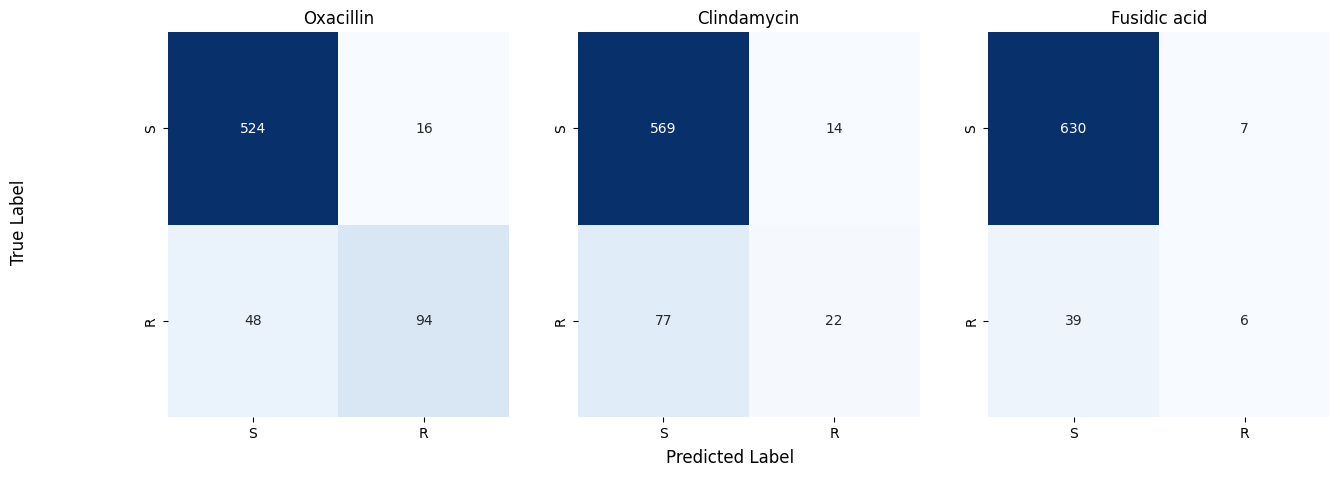

In [20]:
fig, axes = plt.subplots(1, len(antibiotics), figsize=(len(antibiotics)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_c = multilabel_confusion_matrix(test_y, pred)

for i in range(len(antibiotics)):
  sns.heatmap(ax=axes[i], data=cm_svm_c[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=antibiotics[i])